In [ ]:
#hide
from utils import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai2.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular modelling deep dive

## Categorical embeddings

## Beyond deep learning

## The dataset

### Kaggle Competitions

In [ ]:
creds = ''

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [ ]:
path = URLs.path('bluebook')
path

Path('/home/jhoward/.fastai/archive/bluebook')

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('TrainAndValid.csv'),Path('Machine_Appendix.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('median_benchmark.csv'),Path('ValidSolution.csv'),Path('Valid.csv')]

### Look at the data

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [ ]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [ ]:
dep_var = 'SalePrice'

In [ ]:
df[dep_var] = np.log(df[dep_var])

## Decision trees

### Handling dates

In [ ]:
df = add_datepart(df, 'saledate')

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,SalesID_na,MachineID_na,ModelID_na,datasource_na,auctioneerID_na,YearMade_na,MachineHoursCurrentMeter_na,saleYear_na,saleMonth_na,saleWeek_na,saleDay_na,saleDayofweek_na,saleDayofyear_na,saleElapsed_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1163635200,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1080259200,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1077753600,9.210340


In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleDay_na,saleDayofweek_na,saleDayofyear_na,saleElapsed_na
0,1139246,11.097410,999089,3157,...,1,1,1,1
1,1139248,10.950807,117657,77,...,1,1,1,1
2,1139249,9.210340,434808,7009,...,1,1,1,1


In [ ]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

In [ ]:
(path/'to.pkl').save(to)

### Creating the decision tree

In [ ]:
to = (path/'to.pkl').load()

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

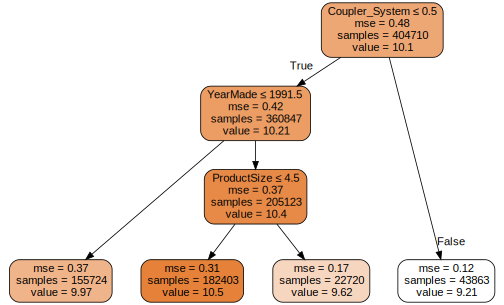

In [ ]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

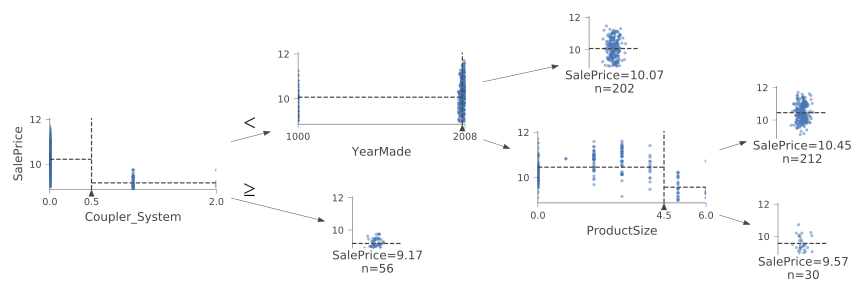

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

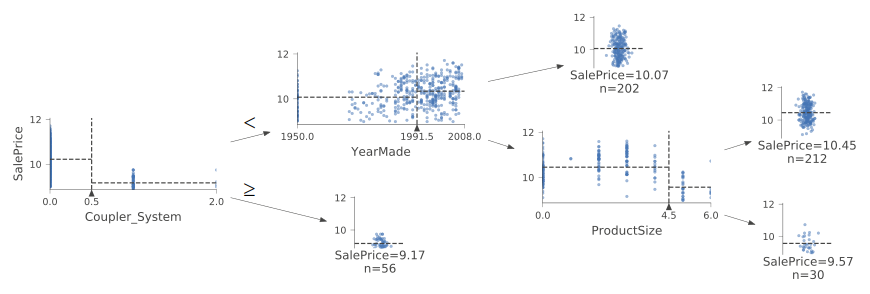

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

0.0

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.337727

In [ ]:
m.get_n_leaves(), len(xs)

(340909, 404710)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.32368)

In [ ]:
m.get_n_leaves()

12397

### Categorical variables

## Random forests

In [ ]:
#hide
# pip install --pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn --U

### Creating a random forest

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170896, 0.233502)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

0.233502

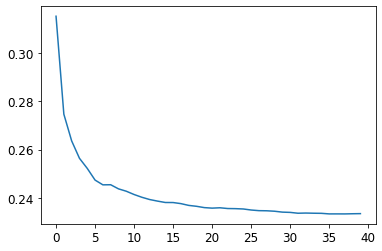

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-bag error

In [ ]:
r_mse(m.oob_prediction_, y)

0.210686

## Model interpretation

### Tree variance for prediction confidence

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 7988)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.21529149, 0.10351274, 0.08901878, 0.28374773, 0.11977206])

### Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
69,YearMade,0.182890
6,ProductSize,0.127268
30,Coupler_System,0.117698
7,fiProductClassDesc,0.069939
66,ModelID,0.057263
77,saleElapsed,0.050113
32,Hydraulics_Flow,0.047091
3,fiSecondaryDesc,0.041225
31,Grouser_Tracks,0.031988
1,fiModelDesc,0.031838


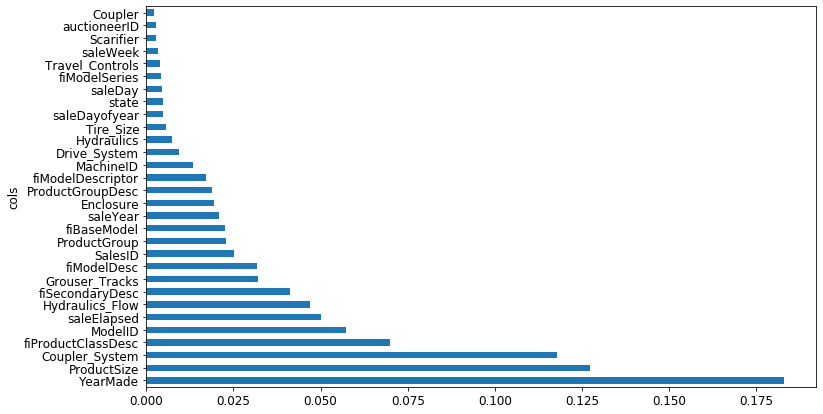

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing low-importance variables

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181208, 0.232323)

In [ ]:
len(xs.columns), len(xs_imp.columns)

(78, 21)

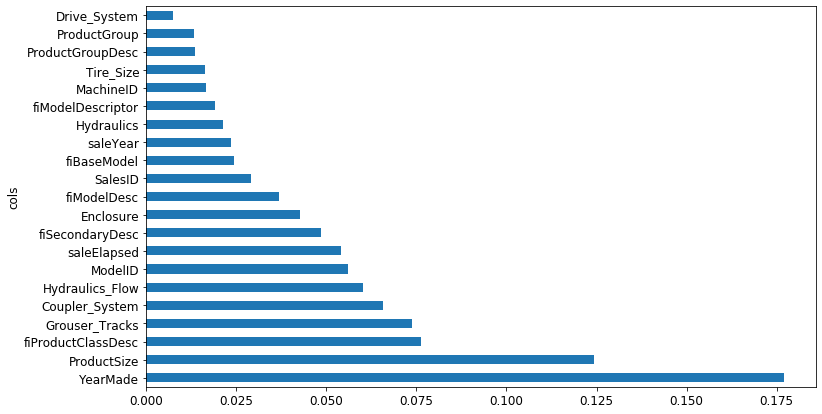

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing redundant features

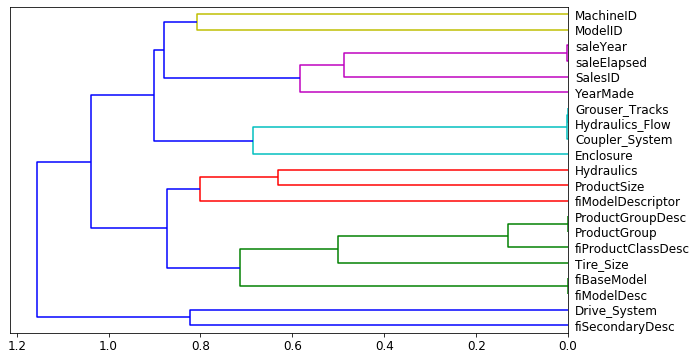

In [ ]:
cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.8771039618198545

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8759666979317242,
 'saleElapsed': 0.8728423449081594,
 'ProductGroupDesc': 0.877877012281002,
 'ProductGroup': 0.8772503407182847,
 'fiModelDesc': 0.8756415073829513,
 'fiBaseModel': 0.8765165299438019,
 'Hydraulics_Flow': 0.8778545895742573,
 'Grouser_Tracks': 0.8773718142788077,
 'Coupler_System': 0.8778016988955392}

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8739605718147015

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [ ]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183263, 0.233846)

### Partial dependence

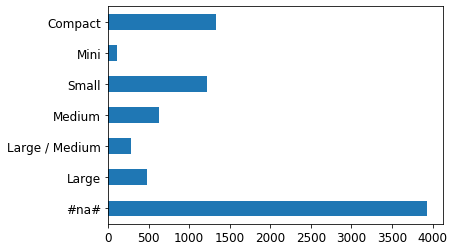

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

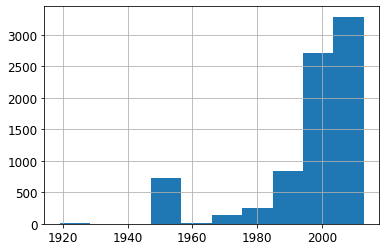

In [ ]:
ax = valid_xs_final['YearMade'].hist()

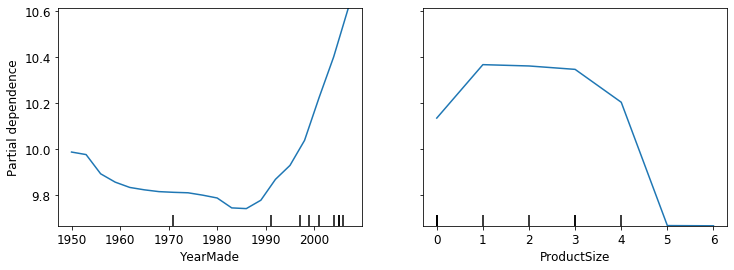

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Data leakage

### Tree interpreter

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98234598]), 10.104309759725059, -0.12196378442186026)

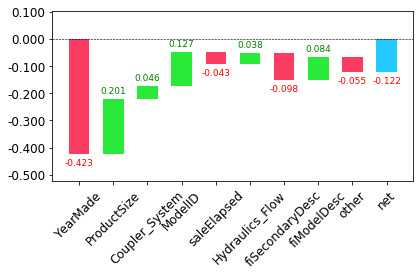

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation and neural networks

### The extrapolation problem

In [ ]:
#hide
np.random.seed(42)

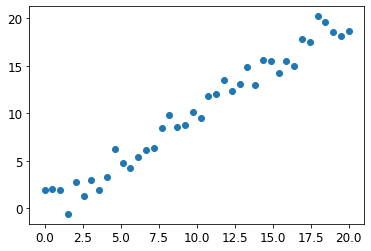

In [ ]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [ ]:
x_lin[:,None].shape

torch.Size([40, 1])

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

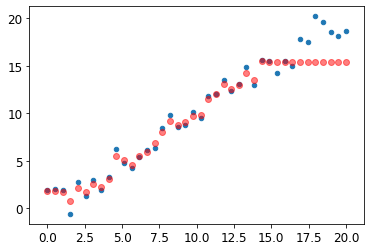

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

### Finding out of domain data

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.859446
9,SalesID,0.119325
13,MachineID,0.014259
0,YearMade,0.001793
8,fiModelDesc,0.001740
11,Enclosure,0.000657


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232795
SalesID 0.23109
saleElapsed 0.236221
MachineID 0.233492


In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.231307

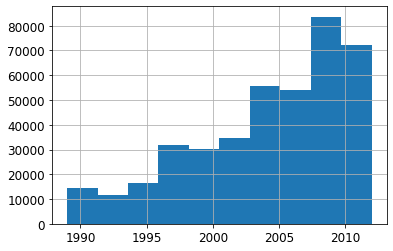

In [ ]:
xs['saleYear'].hist();

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.17768, 0.230631)

### Using a neural network

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
fiModelDesc           5059
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
Drive_System             4
Hydraulics              12
Tire_Size               17
dtype: int64

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176706, 0.230642)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(8.465899897028686, 11.863582336583399)

In [ ]:
from fastai2.tabular.all import *

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

(0.005754399299621582, 0.0002754228771664202)

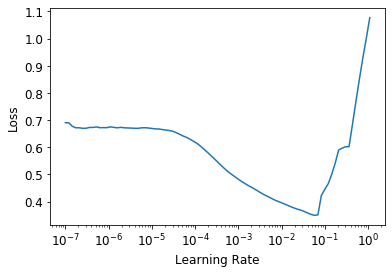

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069705,0.062389,00:11
1,0.056253,0.058489,00:11
2,0.048385,0.052256,00:11
3,0.043400,0.050743,00:11
4,0.040358,0.050986,00:11


In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.2258

In [ ]:
learn.save('nn')

### fastai's Tabular classes

### Ensembling

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds,valid_y)

0.22291

### Boosting

## Combining embeddings with other methods

## Conclusion: our advice for tabular modeling

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide 2 of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kind of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. What is *out of bag error*?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. How can you answer each of these things with a random forest? How do they work?:
   - How confident are we in our projections using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary, as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the *extrapolation problem*?
1. How can you tell if your test or validation set is distributed in a different way to your training set?
1. Why do we make `saleElapsed` a continuous variable, even although it has less than 9000 distinct values?
1. What is boosting?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare yourself to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on this dataset.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).